<a href="https://colab.research.google.com/github/MiroDur/MuScat_Miro/blob/master/Copy_of_twoBeads.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install phantominator
!pip install -U tensorflow-addons

     |████████████████████████████████| 51kB 4.9MB/s 
     |████████████████████████████████| 71kB 5.9MB/s 
ERROR: ellipsinator 0.2.1 has requirement numpy>=1.19.1, but you'll have numpy 1.18.5 which is incompatible.
ERROR: ssfp 0.5.0 has requirement numpy>=1.19.1, but you'll have numpy 1.18.5 which is incompatible.
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1
     |████████████████████████████████| 1.1MB 13.2MB/s 
  Found existing installation: tensorflow-addons 0.8.3
    Uninstalling tensorflow-addons-0.8.3:
      Successfully uninstalled tensorflow-addons-0.8.3


0.35240697860717773
0.37192535400390625


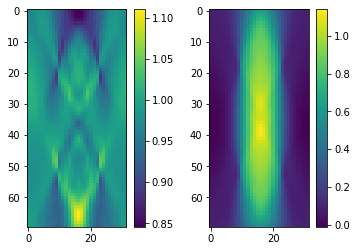

In [ ]:
import sys
sys.path.append('/content/drive/My Drive/MuScat')
from MuScatObject import MuScatObject
from MuScatField import MuScatField
from MuScatParameters import MuScatParameters
from MuScatMicroscopeSim import MuScatMicroscopeSim
import tensorflow as tf
import tensorflow_addons as tfa
import time
import numpy as np
import matplotlib.pyplot as plt


start = time.time()
parameters = MuScatParameters(0.650,        # wavelength in vacuum
                              [70, 32, 32], # gridSize [z, x ,y]
                              0.3,          # dx
                              0.3,          # dy
                              0.3,          # dz
                              1.5,          # refractive index in medium
                              0.5,          # NAc
                              0.95)          # NAo
regLambdaL1 = 0.0003
regLambdaL2 = 0.0#0001
learnRate = 0.08
imagedObject = MuScatObject(parameters)
imagedObject.GenerateTwoBeads(2., 10., 1.52)

imagingSim = MuScatMicroscopeSim(parameters)
refShifts =tf.cast(tf.constant([[0.,0.]]), tf.float32)
imagingSim.Illumination()
imagingSim.Detection()
zPositions = imagedObject.realzzz[::1,0,0] - imagedObject.realzzz[0,0,0]

fieldMeasured = MuScatField(imagingSim.planeWaves, parameters).ComputeMuScat(imagedObject, method='MLB')
zStackMeasured = imagingSim.CCHMImaging(fieldMeasured, zPositions, refShifts)
zStackMeasuredNoisy = zStackMeasured + tf.complex(
    tf.random.normal(tf.shape(zStackMeasured).numpy(), mean=0.0, stddev=0.0005), 
    tf.random.normal(tf.shape(zStackMeasured).numpy(), mean=0.0, stddev=0.0005)
    )
plt.figure(10)
plt.subplot(121),plt.colorbar(plt.imshow(np.abs(zStackMeasuredNoisy[0, :, 16, :])))
plt.subplot(122),plt.colorbar(plt.imshow(np.angle(zStackMeasuredNoisy[0, :, 16, :])))
print(time.time()-start)

optimizedObject = MuScatObject(parameters)
regularizer = tf.keras.regularizers.L1L2(regLambdaL1, regLambdaL2)
#opt = tf.keras.optimizers.Adamax(learning_rate=learnRate)
opt = tfa.optimizers.Yogi(learning_rate=learnRate,
                          l1_regularization_strength = regLambdaL1,
                          l2_regularization_strength = regLambdaL2)

def regTV(variable, parameter):
    diffZ = (variable - tf.roll(variable,1,0))
    diffX = (variable - tf.roll(variable,1,1))
    diffY = (variable - tf.roll(variable,1,2))
    return parameter * tf.reduce_sum(tf.sqrt(diffZ**2 + diffX**2 + diffY**2 + \
                                             tf.keras.backend.epsilon()))
@tf.function
def loss_fn(zStackSimulated, zStackMeasured):
    return tf.reduce_mean(tf.abs(zStackMeasured - zStackSimulated)**2) + regTV(optimizedObject.RIDistrib, 0.00005)
        #regularizer(optimizedObject.RIDistrib) #+ regTV(optimizedObject.RIDistrib, 0.0005)
        
loss = lambda: loss_fn(imagingSim.CCHMImaging(
    MuScatField(imagingSim.planeWaves, parameters).ComputeMuScat(optimizedObject, method='MLB'),
                                              zPositions,
                                              refShifts),
                      zStackMeasuredNoisy)

lossF=[]
for i in range(00):
    opt_op = opt.minimize(loss, var_list=[optimizedObject.RIDistrib])
    if i%20==0:
        #lossF.append(loss().numpy())
        plt.figure(1)
        plt.subplot(131),plt.colorbar(plt.imshow(np.abs(optimizedObject.RIDistrib[:, :, 16]))),plt.clim(0,0.04)
        plt.subplot(132),plt.colorbar(plt.imshow(np.abs(imagedObject.RIDistrib[:, :, 16]))),plt.clim(0,0.04)
        #plt.subplot(133),plt.plot(lossF)
        plt.show()
print(time.time()-start)

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x7f5db728c2b0>)

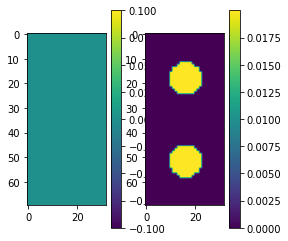

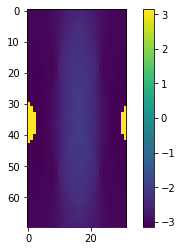

In [ ]:
plt.subplot(131),plt.colorbar(plt.imshow(np.abs(optimizedObject.RIDistrib[:, 16, :])))
plt.subplot(132),plt.colorbar(plt.imshow(np.abs(imagedObject.RIDistrib[:, 16, :])))
plt.figure(2),plt.colorbar(plt.imshow(np.angle(zStackMeasured[0, :, 16, :]*np.exp(1j*np.pi))))
#plt.figure(3),plt.colorbar(plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fftn(imagedObject.RIDistrib))[:, 16, :]))))
#plt.figure(4),plt.colorbar(plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fftn(np.squeeze(zStackMeasured)))[:, 16, :]))))
#plt.figure(5),plt.colorbar(plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fftn(np.squeeze(imagedObject.RIDistrib)))[:, 16, :]))))


(<matplotlib.axes._subplots.AxesSubplot at 0x7fcd400d4c88>,
 <matplotlib.colorbar.Colorbar at 0x7fcd302269e8>)

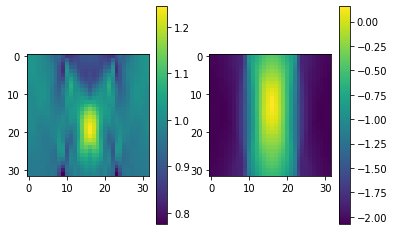

In [ ]:
plt.figure(10)
plt.subplot(121),plt.colorbar(plt.imshow(np.abs(zStackMeasured[0, :, 16, :])))
plt.subplot(122),plt.colorbar(plt.imshow(np.angle(zStackMeasured[0, :, 16, :])))

In [ ]:
!pip install pyevtk
from pyevtk.hl import imageToVTK

imageToVTK(
    "./TwoBeadsRefrInd",
    spacing = (parameters.dz/parameters.dx,1.0,1.0),
    cellData={"RIDistrib": imagedObject.RIDistrib.numpy()},
    
)

'/content/TwoBeadsRefrInd.vti'

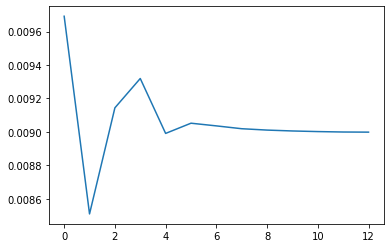

In [ ]:
plt.plot(lossF[1:])
